# EDA

1. __Cargar los datos__

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OrdinalEncoder

<span style="color:pink">Definir la ruta del archivo y cargar dataset</span>


In [ ]:
file_path = "../data/train_test/attrition_availabledata_29.csv"
df = pd.read_csv(file_path)

2. __Información general del dataset__

<span style="color:pink"> Ver las primeras filas del dataset</span>

In [ ]:
df.head()

<span style="color:pink">Información general sobre las variables</span>

In [ ]:
df.info()

3. __identificar el numero de variables e instancias__

In [ ]:
num_filas, num_columnas = df.shape
print(f"Número de instancias: {num_filas}")
print(f"Número de variables: {num_columnas}")

4. __Clasificación de variables__

<span style="color:pink">Qué variables son categóricas/ordinales/numéricas</span>

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
ordinal_cols = ['Education', 'JobLevel', 'StockOptionLevel', 'EnvironmentSatisfaction','JobSatisfaction', 'WorkLifeBalance', 'PerformanceRating']

print(f"Variables categóricas: {categorical_cols}")
print(f"Variables numéricas: {numerical_cols}")
print(f"Variables ordinales: {ordinal_cols}")

5. __Detención de valores nulos__

<span style="color:pink"> Contar valores nulos por columna</span>

In [ ]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(f"Valores faltantes: \n{missing_values}")

6. __Identificar columnas constantes o IDs__

<span style="color:pink"> Identificar columnas con un solo valor</span>

In [ ]:
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print(f"Columnas constantes: {constant_cols}")

<span style="color:pink"> Eliminar las variables constantes </span>

In [ ]:
cols_to_drop = ['EmployeeCount', 'StandardHours']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

7. __Análisis de balance de clases__ (si es un problema de clasificación)

<span style= "color:pink"> Verificar si el dataset esta desbalanceado</span>

In [ ]:
if 'Attrition' in df.columns:
    plt.figure(figsize=(4,4))
    sns.countplot(x='Attrition', data=df, palette='pastel', hue='Attrition', legend=False)
    plt.title("Distribución de la variable objetivo")
    plt.show()
    
    print(df['Attrition'].value_counts(normalize=True) * 100)

8. __Estadísticas descriptivas__

<span style= "color: pink">Estadísticas básicas de las variables numéricas</span>

In [ ]:
df.describe()

9. __Visualización de la distribución de variables numéricas__

<span style= "color:pink">Histogramas para visualizar la distribución de las variables numéricas</span>

In [ ]:

numerical_cols = [col for col in numerical_cols if col in df.columns]

df[numerical_cols].hist(figsize=(15,30), bins=20)
plt.suptitle("Distribución de Variables Numéricas")
plt.show()

# Evaluatión Strategy 

1.__Configuración de semilla__

In [ ]:
RANDOM_STATE = 100474933
np.random.seed(RANDOM_STATE)

2.__Separar variables predictoras y objetivo__

In [ ]:
X = df.drop(columns=['Attrition'])
y = df['Attrition']

3.__División en Train/Test manteniendo la proporción de la clase (estratificación)__

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y, test_size=1/3, random_state=RANDOM_STATE)

<span style= "color:pink"><strong> Filtrar columnas existentes en X_train</strong></span>

In [ ]:
numerical_cols = [col for col in numerical_cols if col in X_train.columns]
categorical_cols = [col for col in categorical_cols if col in X_train.columns]
ordinal_cols = [col for col in ordinal_cols if col in X_train.columns]

print(f"Variables categóricas filtradas: {categorical_cols}")
print(f"Variables numéricas filtradas: {numerical_cols}")
print(f"Variables ordinales filtradas: {ordinal_cols}")

4.__Pipelines de preprocesamiento__

<li style= "color:pink">Transformación para variables categóricas NO ordinales </li>
<li style= "color:pink">Transformación para variables numéricas</li>
<li style= "color:pink">Transformación para variables ordinales</li>


In [ ]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))
])
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])
ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])



5.__Combinación de transformaciones__

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols),
        ('ord', ord_transformer, ordinal_cols)
    ])
preprocessor

6.__Definir pipeline de modelo__

In [ ]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE))
])
clf

7.__Evaluación Interna (Inner Evaluation) con Validación Cruzada__

In [ ]:
cv_score = cross_val_score(clf, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
print(f"\nBalanced Accuracy (CV): {cv_score:.4f}")

8.__Entrenar Modelo con el Mejor Setup__

In [220]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'EmployeeID',
                                                   'JobLevel', 'MonthlyIncome',
                                                   'NumCompaniesWor...
                                                   'JobRole', 'MaritalStatus',
                                                   'Over18']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Education', 'JobLevel',
                                                   'StockOptionLevel',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance',
                                                   'PerformanceRating'])])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=100474933))])

9.__Evaluación Externa (Outer Evaluation) con el Test Set__

In [232]:
y_pred = clf.predict(X_test)

10.__Métricas de Evaluación__

In [231]:
bal_acc = balanced_accuracy_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

11.__Calcular TPR y TNR__

In [230]:
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
tpr = tp / (tp + fn)  # Sensibilidad o Recall para la clase positiva
tnr = tn / (tn + fp)  # Especificidad o Recall para la clase negativa

print(f"\n Evaluación Externa (Outer Evaluation)")
print(f"Balanced Accuracy (Test): {bal_acc:.4f}")
print(f"Accuracy (Test): {acc:.4f}")
print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))



 Evaluación Externa (Outer Evaluation)
Balanced Accuracy (Test): 0.8192
Accuracy (Test): 0.8939
True Positive Rate (TPR): 0.7089
True Negative Rate (TNR): 0.9294

Classification Report:
               precision    recall  f1-score   support

          No       0.94      0.93      0.94       822
         Yes       0.66      0.71      0.68       158

    accuracy                           0.89       980
   macro avg       0.80      0.82      0.81       980
weighted avg       0.90      0.89      0.90       980



12.__Matriz de Confusión__

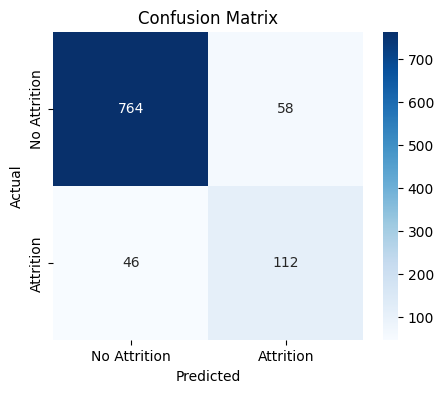

In [233]:
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Attrition", "Attrition"], yticklabels=["No Attrition", "Attrition"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()